<a href="https://colab.research.google.com/github/Gioalf/AH2179/blob/main/project/AIprojectGioAlf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PUBLIC TRANSPORT PROJECT
The project will be divided into two parts, in both cases I will create models that estimate the arrival delay at different stages of the trip:\
* **Part A** will have limited available data, it will be missing all the real time data such as `upstream_stop_delay`, `previous_bus_delay`, `previous_trip_travel_time`, and `travel_time_for_previous_section`

* **Part B** will have all the available data that will lead to a more accurate prediction.

### METHOD
I will use different methods to create prediction models and obtain the best predictions possible, I will then likely use the best model I can get to predict the delays and then check the accuracy of them.\
I can also maybe do some feature engineering and use day of the week and stuff like that.

## DATA HANDLING
Here I will import the dataset and clean it to make it easier to use for my purposes

In [3]:
%pip install pandasql
import pandas as pd
import numpy as np
import pandasql
from pandasql import sqldf

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/ProjectAssignmentData/Dataset-PT.csv'
df = pd.read_csv(url, skiprows=1, header=0)

display(df.head())

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 31 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Calendar_date                      545103 non-null  int64  
 1   route_id                           545103 non-null  int64  
 2   bus_id                             545103 non-null  int64  
 3   stop_sequence                      545103 non-null  int64  
 4   arrival_delay                      545103 non-null  int64  
 5   dwell_time                         545103 non-null  int64  
 6   travel_time_for_previous_section   545103 non-null  int64  
 7   scheduled_travel_time              545103 non-null  int64  
 8   upstream_stop_delay                545103 non-null  int64  
 9   origin_delay                       545103 non-null  int64  
 10  previous_bus_delay                 545103 non-null  int64  
 11  previous_trip_travel_time          5451

I noticed that with the current data I can't associate each row with a specific trip but only with a date and vehicle, so I will add that feature in the most trivial way by just adding a column with a sequential number for each trip.

In [5]:
def trip_counter(group):
    # create a counter that increases every 27 rows
    n_rows = len(group)
    group['trip_number'] = np.arange(n_rows) // 27 + 1
    return group

df = df.groupby('Calendar_date').apply(trip_counter).reset_index(drop=True)

/tmp/ipython-input-3494565459.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Calendar_date').apply(trip_counter).reset_index(drop=True)


In [6]:
df

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,trip_number
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,1,0,1,0,0,1,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,1,0,1,0,0,1,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,1,0,1,0,0,1,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,1,0,1,0,0,1,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,4,41362,23,344,13,74,44,341,12,...,0,0,0,1,1,0,0,0,1,50
545099,20220630,4,41362,24,330,15,34,92,344,12,...,0,0,0,1,1,0,0,0,1,50
545100,20220630,4,41362,25,339,17,63,43,330,12,...,0,0,0,1,1,0,0,0,1,50
545101,20220630,4,41362,26,331,0,35,58,339,12,...,0,0,0,1,1,0,0,0,1,50


In [7]:
 # checking that there is only 27 rows to each date-trip pair so that I didn't make mistakes in the cleaning process
(df.groupby(['Calendar_date', 'trip_number']).size().reset_index(name='count'))['count'].unique()

array([27])

In [8]:
# query = "SELECT DISTINCT Calendar_date, MAX(trip_number) FROM df GROUP BY Calendar_date"
# sqldf(query)

Trying to get some insights and ideas from the data I have

Average Arrival Delay by Stop Sequence:


,stop_sequence,arrival_delay
0,1,63.961117
1,2,100.140274
2,3,92.829660
3,4,65.273961
4,5,107.407251
5,6,138.431671
6,7,128.251226
7,8,106.233593
8,9,136.354797
9,10,161.177473


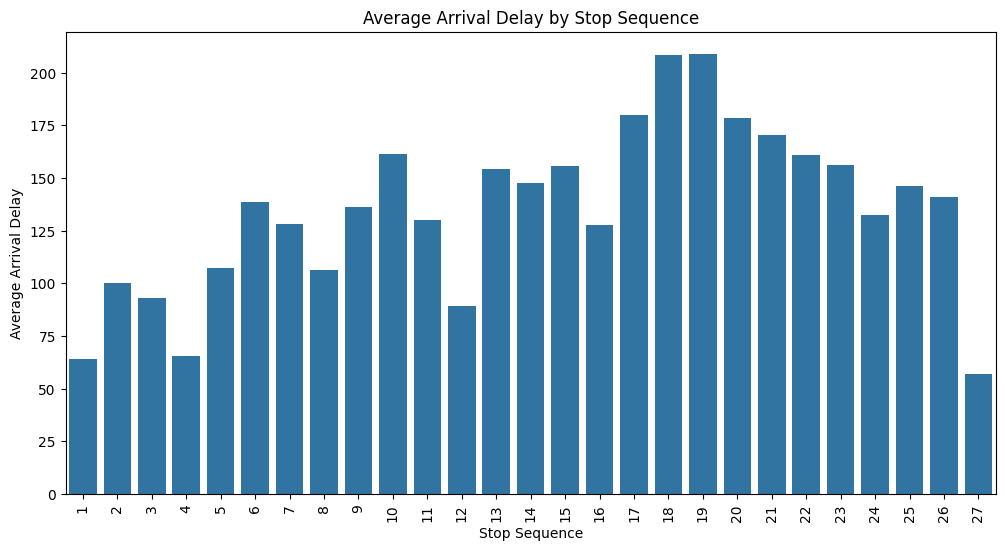

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average arrival delay for each stop sequence
average_delay_by_stop = df.groupby('stop_sequence')['arrival_delay'].mean().reset_index()

# Display the average arrival delay for each stop sequence
print("Average Arrival Delay by Stop Sequence:")
display(average_delay_by_stop)

# Optional: You can still visualize this data if you'd like, for example, with a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=average_delay_by_stop, x='stop_sequence', y='arrival_delay')
plt.title('Average Arrival Delay by Stop Sequence')
plt.xlabel('Stop Sequence')
plt.ylabel('Average Arrival Delay')
plt.xticks(rotation=90)
plt.show()

In [10]:
df.head(25)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,trip_number
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,1,0,1,0,0,1,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,1,0,1,0,0,1,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,1,0,1,0,0,1,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,1,0,1,0,0,1,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,1,0,1,0,0,1,1
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,0,0,1,0,1,0,0,1,1
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,0,0,1,0,1,0,0,1,1
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,0,0,1,0,1,0,0,1,1
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,0,0,1,0,1,0,0,1,1
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,0,0,1,0,1,0,0,1,1


Average Arrival Delay by Stop Sequence and Time of Day:


,stop_sequence,time_of_day,arrival_delay
0,1,AP,54.393781
1,1,MP,34.141484
2,1,OP,74.997470
3,2,AP,93.186565
4,2,MP,61.530490
...,...,...,...
76,26,MP,106.254130
77,26,OP,172.395983
78,27,AP,-23.506765
79,27,MP,19.576449


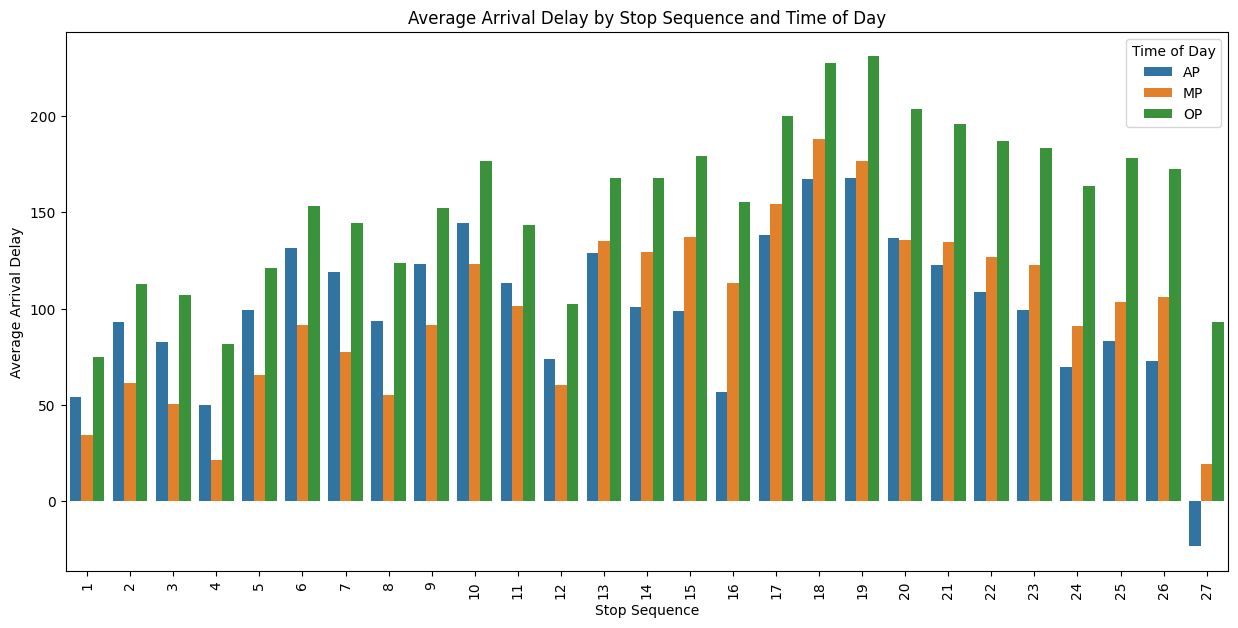

In [11]:
# Calculate the average arrival delay for each stop sequence and time of day
average_delay_by_stop_and_time = df.groupby(['stop_sequence', 'time_of_day'])['arrival_delay'].mean().reset_index()

# Display the average arrival delay by stop sequence and time of day
print("Average Arrival Delay by Stop Sequence and Time of Day:")
display(average_delay_by_stop_and_time)

# Visualize the average arrival delay by stop sequence and time of day using a grouped bar plot
plt.figure(figsize=(15, 7))
sns.barplot(data=average_delay_by_stop_and_time, x='stop_sequence', y='arrival_delay', hue='time_of_day')
plt.title('Average Arrival Delay by Stop Sequence and Time of Day')
plt.xlabel('Stop Sequence')
plt.ylabel('Average Arrival Delay')
plt.xticks(rotation=90)
plt.legend(title='Time of Day')
plt.show()

In [12]:
# Calculate the average arrival delay for each stop sequence and time of day first
average_delay_by_stop_and_time = df.groupby(['stop_sequence', 'time_of_day'])['arrival_delay'].mean().reset_index()

# Now calculate the standard deviation of these average delays for each stop sequence
std_of_average_delay_by_stop = average_delay_by_stop_and_time.groupby('stop_sequence')['arrival_delay'].std().reset_index()

# Display the standard deviation of the average arrival delay by stop sequence
print("Standard Deviation of Average Arrival Delay Across Time of Day for Each Stop Sequence:")
display(std_of_average_delay_by_stop)

Standard Deviation of Average Arrival Delay Across Time of Day for Each Stop Sequence:


,stop_sequence,arrival_delay
0,1,20.428245
1,2,25.787169
2,3,28.469313
3,4,30.210727
4,5,27.900489
5,6,31.228323
6,7,34.022809
7,8,34.500700
8,9,30.368215
9,10,26.782627


## PART A
I will get rid of some of the features that are only available in real time, i.e: `upstream_stop_delay`, `previous_bus_delay`, `previous_trip_travel_time`, `recurrent_delay`, and `travel_time_for_previous_section`

In [36]:
dfA=df.drop(['upstream_stop_delay', 'previous_bus_delay', 'previous_trip_travel_time', 'recurrent_delay', 'travel_time_for_previous_section'], axis=1)

In [37]:
dfA

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,scheduled_travel_time,origin_delay,traffic_condition,weather,...,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,trip_number
0,20220108,4,41344,1,151,0,120,100,168.666667,Light Snow,...,0,0,0,1,0,1,0,0,1,1
1,20220108,4,41344,2,185,24,45,100,46.333333,Light Snow,...,0,0,0,1,0,1,0,0,1,1
2,20220108,4,41344,3,186,0,41,100,36.666667,Light Snow,...,0,0,0,1,0,1,0,0,1,1
3,20220108,4,41344,4,202,12,94,100,88.000000,Light Snow,...,0,0,0,1,0,1,0,0,1,1
4,20220108,4,41344,5,242,21,86,100,102.000000,Light Snow,...,0,0,0,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,4,41362,23,344,13,44,12,32.666667,Normal,...,0,0,0,1,1,0,0,0,1,50
545099,20220630,4,41362,24,330,15,92,12,77.000000,Normal,...,0,0,0,1,1,0,0,0,1,50
545100,20220630,4,41362,25,339,17,43,12,38.000000,Normal,...,0,0,0,1,1,0,0,0,1,50
545101,20220630,4,41362,26,331,0,58,12,50.666667,Normal,...,0,0,0,1,1,0,0,0,1,50


### **MODEL 1**

In this model I will try to do a linear regression on the whole dataset to see what comes out.\
I will add the arrival delay at stop 20 of each run to every row of that run to be used as the target.\
I assume this will perform poorly as it is a huge training of the whole dataset and I will test it from specific stop numbers. I'm not even sure it will run, and also I think it might leak data since I use delays from stops that are further away.

In [38]:
dfA_clean=dfA.copy()

# Filter for rows where stop_sequence is 20
delay_at_stop_20 = dfA_clean[dfA_clean['stop_sequence'] == 20][['Calendar_date', 'trip_number', 'arrival_delay']]

# Rename the 'arrival_delay' column to indicate it's the delay at stop 20
delay_at_stop_20 = delay_at_stop_20.rename(columns={'arrival_delay': 'arrival_delay_stop_20'})

# Merge this information back into dfA_clean
dfA_clean = pd.merge(dfA_clean, delay_at_stop_20, on=['Calendar_date', 'trip_number'], how='left')

# Display the updated DataFrame
dfA_clean



,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,scheduled_travel_time,origin_delay,traffic_condition,weather,...,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,trip_number,arrival_delay_stop_20
0,20220108,4,41344,1,151,0,120,100,168.666667,Light Snow,...,0,0,1,0,1,0,0,1,1,419
1,20220108,4,41344,2,185,24,45,100,46.333333,Light Snow,...,0,0,1,0,1,0,0,1,1,419
2,20220108,4,41344,3,186,0,41,100,36.666667,Light Snow,...,0,0,1,0,1,0,0,1,1,419
3,20220108,4,41344,4,202,12,94,100,88.000000,Light Snow,...,0,0,1,0,1,0,0,1,1,419
4,20220108,4,41344,5,242,21,86,100,102.000000,Light Snow,...,0,0,1,0,1,0,0,1,1,419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,4,41362,23,344,13,44,12,32.666667,Normal,...,0,0,1,1,0,0,0,1,50,274
545099,20220630,4,41362,24,330,15,92,12,77.000000,Normal,...,0,0,1,1,0,0,0,1,50,274
545100,20220630,4,41362,25,339,17,43,12,38.000000,Normal,...,0,0,1,1,0,0,0,1,50,274
545101,20220630,4,41362,26,331,0,58,12,50.666667,Normal,...,0,0,1,1,0,0,0,1,50,274


Now I can remove the unwanted columns of the df

In [39]:
dfA_clean.columns

Index(['Calendar_date', 'route_id', 'bus_id', 'stop_sequence', 'arrival_delay',
       'dwell_time', 'scheduled_travel_time', 'origin_delay',
       'traffic_condition', 'weather', 'temperature', 'day_of_week',
       'time_of_day', 'factor(weather)Light_Rain', 'factor(weather)Light_Snow',
       'factor(weather)Normal', 'factor(weather)Rain', 'factor(weather)Snow',
       'factor(temperature)Cold', 'factor(temperature)Extra_cold',
       'factor(temperature)Normal', 'factor(day_of_week)weekday',
       'factor(day_of_week)weekend', 'factor(time_of_day)Afternoon_peak',
       'factor(time_of_day)Morning_peak', 'factor(time_of_day)Off-peak',
       'trip_number', 'arrival_delay_stop_20'],
      dtype='object')

In [40]:
dfA_clean=dfA_clean.drop(['route_id', 'bus_id', 'weather', 'temperature', 'day_of_week',
       'time_of_day', 'trip_number'], axis=1)

In [41]:
dfA_model1=dfA_clean.copy()
dfA_model1=dfA_model1[dfA_model1['stop_sequence']!=20]

In [42]:
dfA_model1

,Calendar_date,stop_sequence,arrival_delay,dwell_time,scheduled_travel_time,origin_delay,traffic_condition,factor(weather)Light_Rain,factor(weather)Light_Snow,factor(weather)Normal,...,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak,arrival_delay_stop_20
0,20220108,1,151,0,120,100,168.666667,0,1,0,...,0,0,0,1,0,1,0,0,1,419
1,20220108,2,185,24,45,100,46.333333,0,1,0,...,0,0,0,1,0,1,0,0,1,419
2,20220108,3,186,0,41,100,36.666667,0,1,0,...,0,0,0,1,0,1,0,0,1,419
3,20220108,4,202,12,94,100,88.000000,0,1,0,...,0,0,0,1,0,1,0,0,1,419
4,20220108,5,242,21,86,100,102.000000,0,1,0,...,0,0,0,1,0,1,0,0,1,419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,23,344,13,44,12,32.666667,0,0,1,...,0,0,0,1,1,0,0,0,1,274
545099,20220630,24,330,15,92,12,77.000000,0,0,1,...,0,0,0,1,1,0,0,0,1,274
545100,20220630,25,339,17,43,12,38.000000,0,0,1,...,0,0,0,1,1,0,0,0,1,274
545101,20220630,26,331,0,58,12,50.666667,0,0,1,...,0,0,0,1,1,0,0,0,1,274


In [ ]:
import seaborn as sns
sns.pairplot(dfA_model1[['stop_sequence','arrival_delay',
       'dwell_time', 'scheduled_travel_time', 'origin_delay',
       'traffic_condition', 'arrival_delay_stop_20']])

The plots shown above show the potential correlations between each of the factors and also the target feature. We can see that there is an obvious quite-linear correlation between the `arrival_delay`, `origin_delay`, and `arrival_delay_stop_20`, these will probably play a huge role in predicting the value I need.

In [43]:
corr_matrix = dfA_model1.corr()
corr_matrix['arrival_delay_stop_20'].sort_values(ascending=False)

,arrival_delay_stop_20
arrival_delay_stop_20,1.000000e+00
arrival_delay,8.754289e-01
origin_delay,6.698564e-01
factor(day_of_week)weekend,1.899610e-01
factor(time_of_day)Off-peak,1.562884e-01
Calendar_date,1.433879e-01
dwell_time,5.179801e-02
factor(temperature)Normal,3.445202e-02
factor(weather)Normal,2.410104e-02
factor(weather)Rain,9.951747e-03


**I will now define the train data which is going to be 80% of the df then I will test it on different hypothesis**

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

x = dfA_model1.drop(['arrival_delay_stop_20'], axis=1)
y = dfA_model1['arrival_delay_stop_20']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# Create a Linear Regression model
model1 = LinearRegression()

# Fit the model to the training data
model1.fit(X_train_scaled, y_train)

# Predict the test data with the fitted model
y_pred_A1_0 = model1.predict(X_test_scaled)

In [46]:
# Get the coefficients and the feature names
coefficients = model1.coef_
feature_names = X_train.columns

# Create a pandas Series to easily view coefficients with their feature names
coefficients_series = pd.Series(coefficients, index=feature_names)

# Sort the coefficients by their absolute value to see the most influential features
sorted_coefficients = coefficients_series.abs().sort_values(ascending=False)

print("Model Coefficients (sorted by absolute value):")
display(coefficients_series[sorted_coefficients.index])

Model Coefficients (sorted by absolute value):


,0
arrival_delay,179.220476
scheduled_travel_time,27.037494
stop_sequence,-16.844133
traffic_condition,-16.024604
origin_delay,9.785216
Calendar_date,5.163107
dwell_time,-5.078804
factor(time_of_day)Off-peak,4.679610
factor(time_of_day)Afternoon_peak,-3.672733
factor(time_of_day)Morning_peak,-2.078498


In [47]:
mae = mean_absolute_error(y_test, y_pred_A1_0)
mse = mean_squared_error(y_test, y_pred_A1_0)
r2 = r2_score(y_test, y_pred_A1_0)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 69.60612604929483
Mean Squared Error: 9564.049456298508
R-squared: 0.7806411417899002


Now I will try to use some of the test data, specifically the data collected in the rows related to some specific stops\
**TEST AT STOP 1**

In [48]:
X_test_A1_1 = X_test[X_test['stop_sequence'] == 1]
y_test_A1_1 = y_test.loc[X_test_A1_1.index]

# Normalize the features
X_test_scaled_A1_1 = scaler.transform(X_test_A1_1)

# Predict the test data with the fitted model
y_pred_A1_1 = model1.predict(X_test_scaled_A1_1)

mae = mean_absolute_error(y_test_A1_1, y_pred_A1_1)
mse = mean_squared_error(y_test_A1_1, y_pred_A1_1)
r2 = r2_score(y_test_A1_1, y_pred_A1_1)

print(f"Metrics for Stop Sequence 1:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Metrics for Stop Sequence 1:
Mean Absolute Error: 112.44843151170188
Mean Squared Error: 22449.646378480855
R-squared: 0.47900907820568894


**TEST AT STOP 17**

In [49]:
X_test_A1_17 = X_test[X_test['stop_sequence'] == 17]
y_test_A1_17 = y_test.loc[X_test_A1_17.index]

# Normalize the features
X_test_scaled_A1_17 = scaler.transform(X_test_A1_17)

# Predict the test data with the fitted model
y_pred_A1_17 = model1.predict(X_test_scaled_A1_17)

mae = mean_absolute_error(y_test_A1_17, y_pred_A1_17)
mse = mean_squared_error(y_test_A1_17, y_pred_A1_17)
r2 = r2_score(y_test_A1_17, y_pred_A1_17)

print(f"Metrics for Stop Sequence 17:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Metrics for Stop Sequence 17:
Mean Absolute Error: 46.30301196139563
Mean Squared Error: 4180.864860274008
R-squared: 0.9093791450387733


**TEST AT STOP 19**

In [50]:
X_test_A1_19 = X_test[X_test['stop_sequence'] == 19]
y_test_A1_19 = y_test.loc[X_test_A1_19.index]

#Normalize the features
X_test_scaled_A1_19 = scaler.transform(X_test_A1_19)

# Predict the test data with the fitted model
y_pred_A1_19 = model1.predict(X_test_scaled_A1_19)

mae = mean_absolute_error(y_test_A1_19, y_pred_A1_19)
mse = mean_squared_error(y_test_A1_19, y_pred_A1_19)
r2 = r2_score(y_test_A1_19, y_pred_A1_19)

print(f"Metrics for Stop Sequence 19:")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Metrics for Stop Sequence 19:
Mean Absolute Error: 51.54203235307447
Mean Squared Error: 3326.6406341843876
R-squared: 0.9261623114020854


In [51]:
evaluation_results = []

for stop_seq in range(1, 20):  # Loop from stop_sequence 1 to 19 (exclusive of 20)
    # Filter the test data for the current stop sequence
    X_test_seq = X_test[X_test['stop_sequence'] == stop_seq]
    y_test_seq = y_test.loc[X_test_seq.index]

    # Check if there are samples for the current stop sequence
    if not X_test_seq.empty:
        # Normalize the features using the scaler fitted on the training data
        X_test_scaled_seq = scaler.transform(X_test_seq)

        # Predict the test data with the fitted model
        y_pred_seq = model1.predict(X_test_scaled_seq)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test_seq, y_pred_seq)
        mse = mean_squared_error(y_test_seq, y_pred_seq)
        r2 = r2_score(y_test_seq, y_pred_seq)

        # Store the results in a dictionary
        results = {
            'stop_sequence': stop_seq,
            'MAE': mae,
            'MSE': mse,
            'R-squared': r2
        }
        evaluation_results.append(results)
    else:
        print(f"No test samples for stop sequence {stop_seq}")

# Convert the list of dictionaries to a DataFrame for better viewing
evaluation_df = pd.DataFrame(evaluation_results)

# Display the results
print("Evaluation Metrics by Stop Sequence (1 to 19):")
display(evaluation_df)

Evaluation Metrics by Stop Sequence (1 to 19):


,stop_sequence,MAE,MSE,R-squared
0,1,112.448432,22449.646378,0.479009
1,2,107.097240,19998.323194,0.543181
2,3,105.596833,21500.603495,0.494483
3,4,103.918597,19743.881227,0.592520
4,5,96.018527,15858.740788,0.627645
5,6,93.796953,15698.219789,0.638287
6,7,94.209344,14892.626223,0.655071
7,8,90.323189,13994.894736,0.675087
8,9,86.587691,13710.753953,0.669056
9,10,86.704280,13376.763264,0.687928


### **MODEL 2**
In this other case I will try to make multiple models that will only be trained from a specific stop, I will try with linear regression again and if it looks promising I will improve on it

I will now divide the df into smaller df that only contain rows from a specific stop

In [52]:
dfA_model2=dfA_clean.copy()

In [67]:
from sklearn.model_selection import TimeSeriesSplit

df2 = {}
models2 = {}
test_train2={}
results2 = {}

for i in range(1, 21):
    # Filter data for this stop
    dfA_model2_i = dfA_model2[dfA_model2['stop_sequence'] == i].copy()
    df2[f'stop_{i}'] = dfA_model2_i

    # Drop non-predictive columns
    dfA_model2_i = dfA_model2_i.drop(['Calendar_date', 'stop_sequence'], axis=1)

    # Define features and target
    X = dfA_model2_i.drop(['arrival_delay_stop_20'], axis=1)
    y = dfA_model2_i['arrival_delay_stop_20']

    # Split chronologically: first 80% train, last 20% test
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    test_train2[f'stop_{i}'] = {'X_train_scaled': X_train_scaled, 'X_test_scaled': X_test_scaled, 'y_train': y_train, 'y_test': y_test}

    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Evaluate on the test set
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    models2[f'model_stop_{i}'] = model
    results2[f'stop_{i}'] = {'R2': r2, 'MAE': mae, 'MSE': mse}

# Display performance summary
pd.DataFrame(results2).T



,R2,MAE,MSE
stop_1,0.636019,1.185766e+02,2.424213e+04
stop_2,0.671589,1.136772e+02,2.187307e+04
stop_3,0.682295,1.121373e+02,2.116001e+04
stop_4,0.708166,1.078206e+02,1.943694e+04
stop_5,0.742939,1.012861e+02,1.712099e+04
stop_6,0.756807,9.873222e+01,1.619732e+04
stop_7,0.769776,9.609976e+01,1.533357e+04
stop_8,0.779971,9.391706e+01,1.465456e+04
stop_9,0.794951,9.020748e+01,1.365681e+04
stop_10,0.802046,8.826342e+01,1.318428e+04


Random plot of expected vs actual values for a specific stop

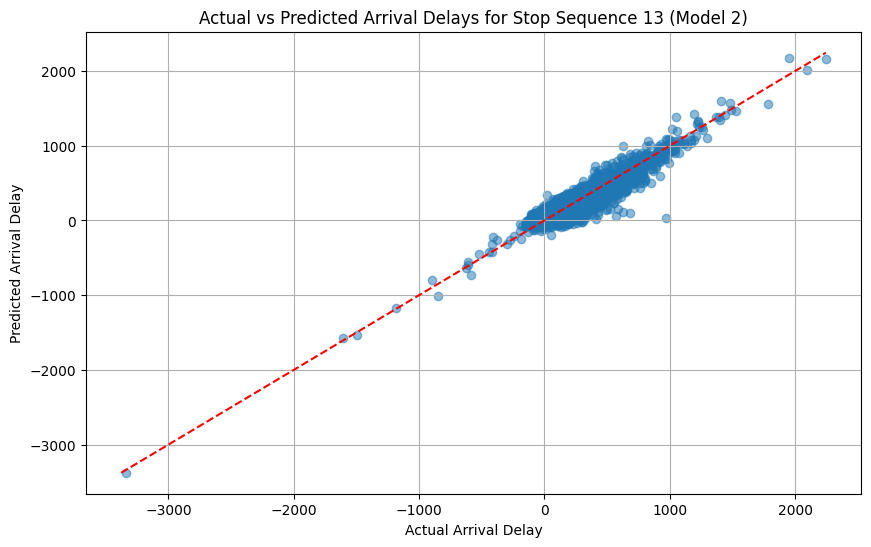

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Get the scaled test data and true values for stop 13 from the test_train2 dictionary
X_test_scaled_stop13 = test_train2['stop_13']['X_test_scaled']
y_test_stop13 = test_train2['stop_13']['y_test']

# Get the trained model for stop 13 from the models2 dictionary
model_stop13 = models2['model_stop_13']

# Make predictions on the scaled test set for stop 13
y_pred_stop13 = model_stop13.predict(X_test_scaled_stop13)

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_stop13, y_pred_stop13, alpha=0.5)

# Add a diagonal line
max_val = max(y_test_stop13.max(), y_pred_stop13.max())
min_val = min(y_test_stop13.min(), y_pred_stop13.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')


plt.title('Actual vs Predicted Arrival Delays for Stop Sequence 13 (Model 2)')
plt.xlabel('Actual Arrival Delay')
plt.ylabel('Predicted Arrival Delay')
plt.grid(True)
plt.show()

In [65]:
# Get the coefficients and the feature names
coefficients = models2['model_stop_18'].coef_
feature_names = X_train.columns

# Create a pandas Series to easily view coefficients with their feature names
coefficients_series = pd.Series(coefficients, index=feature_names)

# Sort the coefficients by their absolute value to see the most influential features
sorted_coefficients = coefficients_series.abs().sort_values(ascending=False)

print("Model Coefficients (sorted by absolute value):")
display(coefficients_series[sorted_coefficients.index])

Model Coefficients (sorted by absolute value):


,0
arrival_delay,193.176882
scheduled_travel_time,-9.008840
factor(time_of_day)Morning_peak,-5.085273
factor(day_of_week)weekday,3.525778
factor(day_of_week)weekend,-3.525778
factor(time_of_day)Off-peak,3.136529
origin_delay,-2.797711
factor(temperature)Extra_cold,-0.929912
factor(time_of_day)Afternoon_peak,0.924084
traffic_condition,0.865926


### **MODEL 3**
Now I'll try to do the same with XGBoost as the model to compare performance.

In [56]:
# !pip install xgboost

In [57]:
dfA_model3=dfA_clean.copy()

In [62]:
from xgboost import XGBRegressor

df3 = {}
models3 = {}
results3 = {}

for i in range(1, 21):
    # Filter data for this stop
    dfA_model3_i = dfA_model3[dfA_model3['stop_sequence'] == i].copy()
    df3[f'stop_{i}'] = dfA_model3_i

    # Drop non-predictive columns
    dfA_model3_i = dfA_model3_i.drop(['Calendar_date', 'stop_sequence'], axis=1)

    # Define features and target
    X = dfA_model3_i.drop(['arrival_delay_stop_20'], axis=1)
    y = dfA_model3_i['arrival_delay_stop_20']

    # Split chronologically: first 80% train, last 20% test
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train XGBoost model
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=1,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Store model and metrics
    models3[f'model_stop_{i}'] = model
    results3[f'stop_{i}'] = {'R2': r2, 'MAE': mae, 'MSE':mse}

# Display summary
pd.DataFrame(results3).T


,R2,MAE,MSE
stop_1,0.537620,121.485603,30795.771484
stop_2,0.571465,116.503914,28541.587891
stop_3,0.576652,115.419624,28196.144531
stop_4,0.608384,110.552399,26082.703125
stop_5,0.655739,103.107910,22928.693359
stop_6,0.661550,101.338455,22541.673828
stop_7,0.675799,98.236862,21592.646484
stop_8,0.692650,95.265091,20470.322266
stop_9,0.701899,93.632729,19854.339844
stop_10,0.718950,90.667656,18718.669922


In [61]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error

# Filter data for stop 19
df_stop19 = df3['stop_19']

# Features and target
X = df_stop19.drop(['arrival_delay_stop_20'], axis=1)
y = df_stop19['arrival_delay_stop_20']

# Chronological split: first 80% train, last 20% test
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define XGBoost model
xgb = XGBRegressor(random_state=42)

# Parameter grid for GridSearch
param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Use negative MAE as scoring (lower MAE is better)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=scorer,
    cv=4,             # just 3-fold CV inside the train set
    verbose=1,
    n_jobs=-1
)

# Fit GridSearch on training data only
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)
print("Best CV MAE (negative):", grid_search.best_score_)

# Evaluate on test set
best_model_stop19 = grid_search.best_estimator_
y_pred_test = best_model_stop19.predict(X_test_scaled)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = best_model_stop19.score(X_test_scaled, y_test)

print("Test MAE:", test_mae)
print("Test R²:", test_r2)


Fitting 4 folds for each of 32 candidates, totalling 128 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best CV MAE (negative): -16.542569398880005
Test MAE: 28.860687255859375
Test R²: 0.8963830471038818


With these tests I saw that I don't get many improvements by using XGBoost, and it would take too long to calibrate each model individually even with gridsearch, so this method is discarded.

#### **MODEL 4**
I will do some PCA on the features dataset to potentially remove some outliers. I will start with one and then if it seems significant I will try with more.

In [76]:
from sklearn.decomposition import PCA

df4 = df2.copy()

# Drop non-predictive columns
df4['stop_1'] = df4['stop_1'].drop(['Calendar_date', 'stop_sequence'], axis=1)

# Define features and target
X = df4['stop_1'].drop(['arrival_delay_stop_20'], axis=1)
y = df4['stop_1']['arrival_delay_stop_20']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

pca = PCA(n_components=7)  # Adjust the number of components (dimensions) as needed
X_pca = pca.fit_transform(X_scaled)
print(X_pca)
print(X_pca.shape)

# Investigate Explained Variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance Ratio: {explained_variance}')
print(f"Sum of the explained variance: {sum(explained_variance)}")

[[ 3.34050735e+00 -4.03856678e+00 -3.61667879e+00 ...  9.26335780e-01
   2.47187017e+00  2.05558994e+00]
 [ 3.04335368e+00 -4.27884244e+00 -3.84962820e+00 ...  6.49275466e-01
   2.47428174e+00  2.04589611e+00]
 [ 3.01259309e+00 -4.30328486e+00 -3.89061664e+00 ...  6.92351342e-01
   2.44568516e+00  2.06829715e+00]
 ...
 [ 6.11396757e-01  1.93420304e-01  9.89731502e-02 ...  5.34282147e-01
   5.16159854e-01 -3.17797317e-01]
 [ 5.60258985e-01  1.65387975e-01  7.95776703e-02 ...  3.89186798e-01
   5.51763060e-01 -3.54816124e-01]
 [ 4.83202380e-01  1.01265459e-01 -2.27317153e-03 ...  4.10134767e-01
   5.15762887e-01 -3.26453346e-01]]
(20189, 7)
Explained Variance Ratio: [0.1665742  0.11872703 0.11044326 0.1004658  0.07395388 0.06521216
 0.06361688]
Sum of the explained variance: 0.6989932068902833
